# Introduction to Electricity Markets

| Information | Details |
|------------|----------|
| Learning Objectives | • Understand why electricity markets replaced regulated monopolies<br>• Calculate market clearing prices and economic surplus<br>• Explain locational marginal pricing and congestion<br>• Analyze day-ahead and real-time market settlements<br>• Identify basic market power and mitigation strategies |
| Prerequisites | Linear programming with PuLP, basic economics, power systems fundamentals |
| Estimated Time | 120 minutes |
| Topics | Market clearing, merit order, LMP, two-settlement systems, market power |

## Introduction

Electricity markets coordinate billions of dollars in daily transactions while maintaining the delicate physics of a balanced grid. Unlike other commodities, electricity cannot be economically stored at scale and must be produced the instant it's consumed. This fundamental constraint, combined with the critical nature of electricity supply, creates unique market design challenges that don't exist in other industries.

For most of the 20th century, electricity was provided by vertically integrated utilities that owned generation, transmission, and distribution assets. Regulators set rates to cover costs plus a fair return on investment. While this model ensured universal service and reliability, it provided little incentive for efficiency or innovation. Generation decisions were made through central planning rather than competition, often leading to overcapacity and higher costs for consumers.

The restructuring movement that began in the 1990s introduced competition into electricity generation while maintaining regulated monopolies for transmission and distribution. This hybrid model aims to harness market forces where competition is viable while preserving regulation where natural monopolies exist. Today's electricity markets must balance multiple objectives: minimizing costs, ensuring reliability, providing fair compensation to generators, and creating appropriate investment signals for new capacity.

This lesson introduces the fundamental concepts that enable competitive electricity markets to function efficiently. You'll learn how prices are discovered through the interaction of supply and demand, why prices vary by location due to transmission constraints, and how financial settlements work across multiple time horizons. These concepts form the foundation for understanding modern grid operations and the integration of renewable energy resources.

## Setting Up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pulp import *
import warnings
warnings.filterwarnings('ignore')

# Set display precision for cleaner output
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:.2f}'.format

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

## Economic Efficiency and Market Clearing

Markets exist to allocate scarce resources efficiently. In electricity, this means dispatching the lowest-cost generators to meet demand, a principle known as economic dispatch. The market clearing process determines both which generators produce power and the price all generators receive. This single clearing price, despite generators having different costs, creates powerful incentives for efficiency and innovation.

To understand market clearing, consider how supply and demand interact. Generators submit offers indicating how much they're willing to produce at different prices, while consumers (through their retailers or utilities) express demand. The market operator stacks generators from lowest to highest cost, creating the supply curve. The intersection with demand determines both the clearing price and which generators are dispatched.

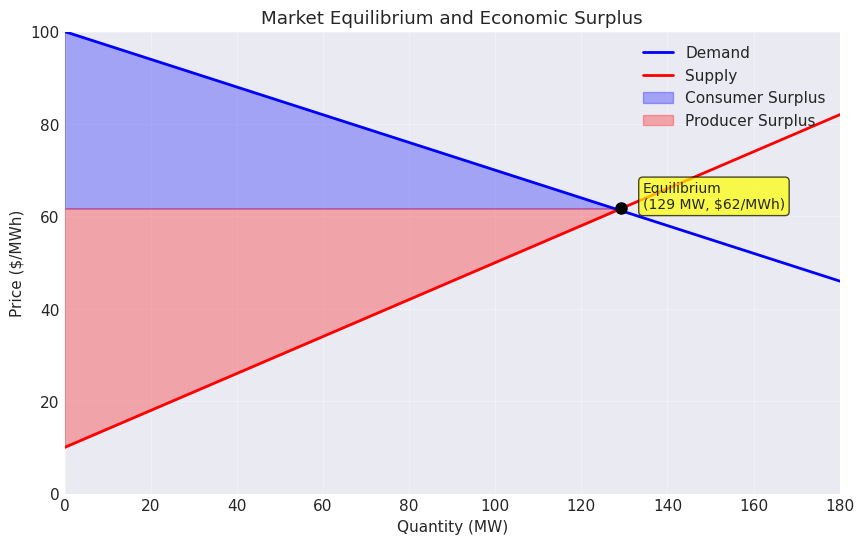

In [2]:
# Visualize supply, demand, and economic surplus
quantity = np.linspace(0, 200, 100)
demand = 100 - 0.3 * quantity
supply = 10 + 0.4 * quantity

# Find equilibrium
eq_idx = np.argmin(np.abs(demand - supply))
eq_q = quantity[eq_idx]
eq_p = supply[eq_idx]

plt.figure(figsize=(10, 6))
plt.plot(quantity, demand, 'b-', linewidth=2, label='Demand')
plt.plot(quantity, supply, 'r-', linewidth=2, label='Supply')
plt.fill_between(quantity[:eq_idx], eq_p, demand[:eq_idx], 
                 alpha=0.3, color='blue', label='Consumer Surplus')
plt.fill_between(quantity[:eq_idx], supply[:eq_idx], eq_p,
                 alpha=0.3, color='red', label='Producer Surplus')
plt.plot(eq_q, eq_p, 'ko', markersize=8)
plt.text(eq_q + 5, eq_p, f'Equilibrium\n({eq_q:.0f} MW, ${eq_p:.0f}/MWh)',
         fontsize=10, bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
plt.xlabel('Quantity (MW)')
plt.ylabel('Price ($/MWh)')
plt.title('Market Equilibrium and Economic Surplus')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.xlim(0, 180)
plt.ylim(0, 100)
plt.show()

The shaded areas in the figure represent economic surplus; the total benefit created by the market. Consumer surplus (blue) captures the value consumers receive above what they pay, while producer surplus (red) represents generator profits above their costs. Competitive markets maximize this total surplus, ensuring resources are allocated to their highest-value uses. In contrast, regulated monopolies may set prices that create deadweight loss, reducing overall economic efficiency.

## Merit Order Dispatch

The foundation of electricity market operations is the merit order principle: generators are dispatched in order of increasing marginal cost until demand is met. This ensures the lowest-cost resources are always used first, minimizing total production costs. The last generator needed to meet demand, called the marginal unit, sets the market clearing price that all generators receive.

This uniform pricing might seem counterintuitive—why should a low-cost generator receive the same price as an expensive one? The answer lies in incentive compatibility. Uniform pricing encourages generators to bid their true costs, as bidding higher risks not being dispatched while bidding lower means selling at a loss. This truthful bidding is essential for efficient market outcomes.

In [3]:
# Create generator data
generators = pd.DataFrame({
    'name': ['Nuclear', 'Coal_1', 'Coal_2', 'Gas_CC', 'Gas_CT'],
    'capacity': [400, 300, 250, 200, 150],
    'marginal_cost': [10, 25, 28, 35, 55]
})

# Sort by marginal cost to create merit order
generators = generators.sort_values('marginal_cost')
generators['cumulative_capacity'] = generators['capacity'].cumsum()

print("Merit Order Stack:")
print(generators[['name', 'capacity', 'marginal_cost']])

Merit Order Stack:
      name  capacity  marginal_cost
0  Nuclear       400             10
1   Coal_1       300             25
2   Coal_2       250             28
3   Gas_CC       200             35
4   Gas_CT       150             55


Now let's implement the market clearing algorithm. The market operator collects all supply offers, sorts them by price, and dispatches generators until demand is satisfied. This simple mechanism, despite its elegance, efficiently coordinates thousands of generators in real power systems.

In [4]:
def clear_market(generators, demand):
    """Simple market clearing algorithm."""
    generators = generators.sort_values('marginal_cost')
    cumulative = 0
    dispatch = []
    clearing_price = 0
    
    for _, gen in generators.iterrows():
        if cumulative < demand:
            dispatched = min(gen['capacity'], demand - cumulative)
            dispatch.append({
                'name': gen['name'],
                'dispatch': dispatched,
                'marginal_cost': gen['marginal_cost']
            })
            cumulative += dispatched
            if cumulative >= demand:
                clearing_price = gen['marginal_cost']
                break
    
    return pd.DataFrame(dispatch), clearing_price

# Run market clearing
demand = 850  # MW
dispatch, price = clear_market(generators, demand)

print(f"\nDemand: {demand} MW")
print(f"Clearing Price: ${price}/MWh\n")
print("Dispatch Results:")
print(dispatch)


Demand: 850 MW
Clearing Price: $28/MWh

Dispatch Results:
      name  dispatch  marginal_cost
0  Nuclear       400             10
1   Coal_1       300             25
2   Coal_2       150             28


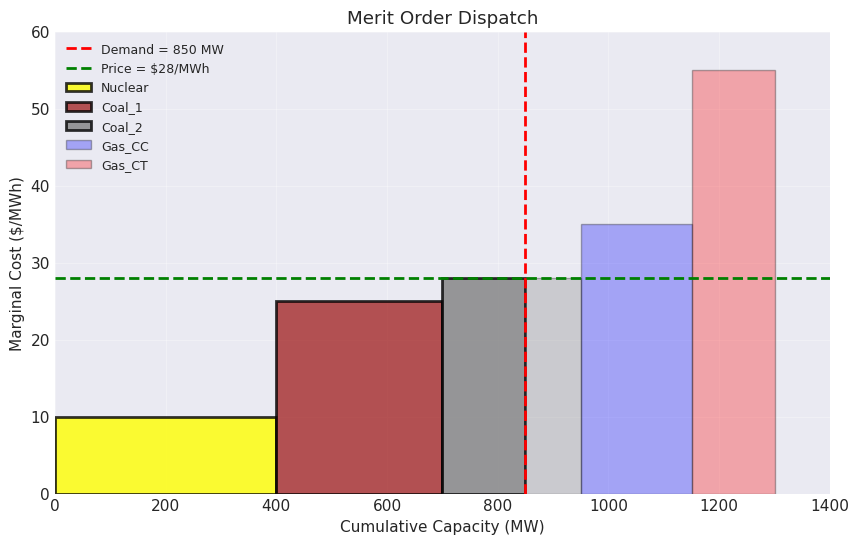

In [5]:
# Visualize dispatch stack
fig, ax = plt.subplots(figsize=(10, 6))

# Draw supply stack
left = 0
colors = {'Nuclear': 'yellow', 'Coal_1': 'brown', 'Coal_2': 'gray', 
          'Gas_CC': 'blue', 'Gas_CT': 'red'}

for _, gen in generators.iterrows():
    width = gen['capacity']
    height = gen['marginal_cost']
    color = colors.get(gen['name'], 'gray')
    
    # Check if dispatched
    if gen['name'] in dispatch['name'].values:
        alpha = 0.8
        dispatched = dispatch[dispatch['name'] == gen['name']]['dispatch'].values[0]
        ax.bar(left + dispatched/2, height, dispatched, 
               color=color, alpha=alpha, edgecolor='black', linewidth=2,
               label=gen['name'])
        
        # Draw undispatched portion if partially dispatched
        undispatched = width - dispatched
        if undispatched > 0:
            ax.bar(left + dispatched + undispatched/2, height, undispatched,
                   color=color, alpha=0.3, edgecolor='black', linewidth=1)
    else:
        alpha = 0.3
        ax.bar(left + width/2, height, width,
               color=color, alpha=alpha, edgecolor='black', linewidth=1,
               label=gen['name'])
    
    left += width

# Draw demand and price lines
ax.axvline(x=demand, color='red', linestyle='--', linewidth=2, label=f'Demand = {demand} MW')
ax.axhline(y=price, color='green', linestyle='--', linewidth=2, label=f'Price = ${price}/MWh')

ax.set_xlabel('Cumulative Capacity (MW)')
ax.set_ylabel('Marginal Cost ($/MWh)')
ax.set_title('Merit Order Dispatch')
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1400)
ax.set_ylim(0, 60)
plt.show()

## Producer Surplus and Market Incentives

Producer surplus, which is the difference between the market price and a generator's marginal cost, provides crucial economic signals. Efficient generators with costs below the clearing price earn substantial profits, incentivizing investment in low-cost technologies. Conversely, expensive generators that rarely run earn little profit, signaling they may need to retire or improve efficiency.

This profit mechanism might appear to reward generators unfairly, especially when low-cost units earn high profits during scarcity. However, these profits serve an essential function: they signal where new investment is needed and compensate generators for their fixed costs. Without adequate producer surplus, generators cannot recover their capital investments, leading to underinvestment and eventual reliability problems.

In [6]:
# Calculate producer surplus
dispatch['producer_surplus'] = (price - dispatch['marginal_cost']) * dispatch['dispatch']
total_surplus = dispatch['producer_surplus'].sum()

print("Producer Surplus by Generator:")
for _, row in dispatch.iterrows():
    print(f"  {row['name']:8} ${row['producer_surplus']:,.0f}")
print(f"\nTotal Producer Surplus: ${total_surplus:,.0f}")

Producer Surplus by Generator:
  Nuclear  $7,200
  Coal_1   $900
  Coal_2   $0

Total Producer Surplus: $8,100


## Locational Marginal Pricing

The previous section introduced economic dispatch without considering transmission constraints. In reality, electricity cannot flow freely to any location. Transmission lines have physical limits that constrain how power moves through the network. These constraints fundamentally change how markets clear and create different prices at different locations, a phenomenon captured through Locational Marginal Pricing (LMP).

This section demonstrates how transmission constraints affect market outcomes using Power Transfer Distribution Factors (PTDF), a linear relationship between power injections and line flows that will be covered in the next lesson. Here, we will show how congestion creates price separation across the network and build the intuition into the price differences.

We use two functions defined in the [PTDF lesson](ptdf) for building the B matrix and PTDF matrix. 

Bus Data:
      bus_id  bus_type  demand
Bus1       1         3       0
Bus2       2         1     100
Bus3       3         1      80

Line Data:
   from_bus to_bus  reactance  limit
L1     Bus1   Bus2       0.10    120
L2     Bus1   Bus3       0.15    100
L3     Bus2   Bus3       0.20     80
B Matrix (Susceptance Matrix):
       Bus1   Bus2  Bus3
Bus1  16.67 -10.00 -6.67
Bus2 -10.00  15.00 -5.00
Bus3  -6.67  -5.00 11.67

Matrix properties:
- Symmetric: True
- Singular (rows sum to 0): True
Slack bus identified: Bus1 (index 0)

PTDF Matrix:
           Bus1  Bus2  Bus3
Bus1-Bus2  0.00 -0.78 -0.33
Bus1-Bus3  0.00 -0.22 -0.67
Bus2-Bus3  0.00  0.22 -0.33
PTDF Validation:
1. Row sums (should be ≈ 0 for power conservation):
   L1: -1.111111
   L2: -0.888889
   L3: -0.111111

2. Test injection: 100 MW at Bus2
   (Slack bus automatically provides -100 MW)
   Resulting line flows:
   L1: -77.78 MW
   L2: -22.22 MW
   L3: 22.22 MW

3. Power balance at each bus:
   Bus1: Expected=-100 MW, Actual=

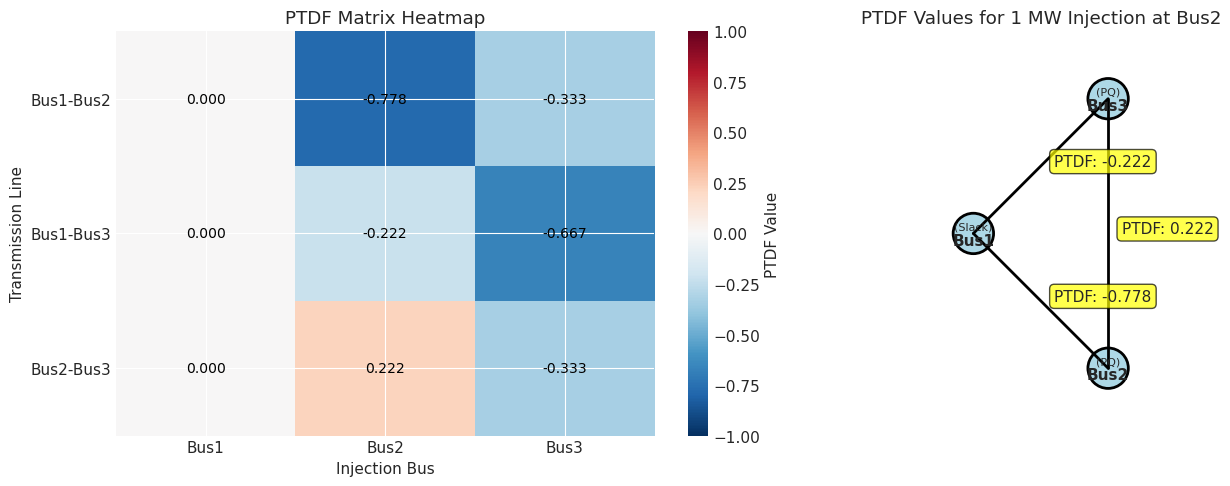

Generation Shift Factors (Bus3 → Bus1):
L1: 0.3333
L2: 0.6667
L3: 0.3333

Interpretation:
Shifting 10 MW from Bus3 to Bus1 would change flows by:
L1: +3.33 MW
L2: +6.67 MW
L3: +3.33 MW
LODF Matrix:
(Row = monitored line, Column = outaged line)
           Bus1-Bus2  Bus1-Bus3  Bus2-Bus3
Bus1-Bus2      -1.00       1.00      -1.00
Bus1-Bus3       1.00      -1.00       1.00
Bus2-Bus3      -1.00       1.00      -1.00
Base Case Flows:
L1: 77.78 MW (Limit: 120 MW)
L2: 22.22 MW (Limit: 100 MW)
L3: -22.22 MW (Limit: 80 MW)

Contingency Analysis: Outage of L1
Pre-contingency flow on outaged line: 77.78 MW

  Line  Base Flow (MW)  Post-Cont Flow (MW)  Change (MW)  Limit (MW)  \
0   L1           77.78                 0.00       -77.78         120   
1   L2           22.22               100.00        77.78         100   
2   L3          -22.22              -100.00       -77.78          80   

   Post-Cont Loading (%)  
0                   0.00  
1                 100.00  
2                 125.00  

In [7]:
%run ptdf.ipynb

### Network Data

A modified 3-bus network will be used to demonstrate how transmission constraints create locational prices. The network has two generators: cheap generation at Bus 1 and more expensive generation at Bus 2. Load centers at Bus 2 and Bus 3 create power flows that will stress certain transmission paths.

In [8]:
def create_3bus_network():
    """Create a 3-bus test network."""
    
    # Bus data with bus types (3 = slack, 1 = PQ)
    buses = pd.DataFrame({
        'bus_id': [1, 2, 3],
        'bus_type': [3, 1, 1],  # Bus 1 is slack
        'demand': [0, 75, 75]  # MW, will vary
    }, index=['Bus1', 'Bus2', 'Bus3'])
    
    # Generator data
    generators = pd.DataFrame({
        'bus': ['Bus1', 'Bus2'],
        'p_max': [250, 100],
        'p_min': [0, 0],
        'cost': [20, 40]  # $/MWh
    }, index=['G1_Cheap', 'G2_Expensive'])
    
    # Line data with reactances and limits
    lines = pd.DataFrame({
        'from_bus': ['Bus1', 'Bus1', 'Bus2'],
        'to_bus': ['Bus2', 'Bus3', 'Bus3'],
        'reactance': [0.1, 0.15, 0.2],  # p.u.
        'limit': [100, 200, 200]  # MW
    }, index=['L1_1-2', 'L2_1-3', 'L3_2-3'])
    
    return buses, generators, lines

# Create and display the network
buses, generators, lines = create_3bus_network()

In [9]:
print("Network Configuration:")
print("="*50)
print("\nGenerators:")
print(generators)
print("\nLoad Distribution:")
print(buses[['demand']])
print(f"\nTotal Load: {buses['demand'].sum()} MW")
print(f"Total Generation Capacity: {generators['p_max'].sum()} MW")

Network Configuration:

Generators:
               bus  p_max  p_min  cost
G1_Cheap      Bus1    250      0    20
G2_Expensive  Bus2    100      0    40

Load Distribution:
      demand
Bus1       0
Bus2      75
Bus3      75

Total Load: 150 MW
Total Generation Capacity: 350 MW


In [10]:
ptdf, slack_idx = calculate_ptdf(buses, lines)

print("PTDF Matrix:")
print(ptdf)

Slack bus identified: Bus1 (index 0)
PTDF Matrix:
[[ 0.   -0.78 -0.33]
 [ 0.   -0.22 -0.67]
 [ 0.    0.22 -0.33]]


The PTDF matrix reveals important network characteristics. Notice that injections at the slack bus (Bus1) have zero PTDF values because the slack bus absorbs imbalances. The negative values indicate power flowing in the opposite direction of the defined line orientation. For example, an injection at Bus 2 causes -0.778 of that power to flow from Bus 1 to Bus 2 (negative because Bus 2 is receiving).

In [11]:
def solve_3bus_opf(buses, generators, lines, ptdf, bus_map):
    """
    Solve economic dispatch with transmission constraints using PTDF.
    
    This formulation models how power injections create line flows,
    enabling correct LMP calculation from dual variables.
    """
    
    line_limits = lines['limit'].values
    
    # Create optimization problem
    prob = LpProblem("Network_Constrained_ED", LpMinimize)
    
    # Decision variables: generator outputs
    gen_vars = {}
    for gen_id in generators.index:
        gen_vars[gen_id] = LpVariable(
            f"Gen_{gen_id}", 
            generators.loc[gen_id, 'p_min'],
            generators.loc[gen_id, 'p_max']
        )
    
    # Objective: minimize total generation cost
    prob += lpSum([gen_vars[g] * generators.loc[g, 'cost'] for g in generators.index])
    
    # Constraint 1: Power balance
    total_demand = buses['demand'].sum()
    prob += (lpSum(gen_vars[g] for g in generators.index) == total_demand, 
             "Power_Balance")
    
    # Constraint 2: Transmission limits using PTDF
    for line_idx, line_name in enumerate(lines.index):
        # Calculate line flow as PTDF × net injections
        flow_expr = 0
        
        for bus_name in buses.index:
            bus_idx = bus_map[bus_name]
            
            # Generation at this bus
            gen_at_bus = generators[generators['bus'] == bus_name].index
            if len(gen_at_bus) > 0:
                gen_injection = lpSum(gen_vars[g] for g in gen_at_bus)
            else:
                gen_injection = 0
            
            # Net injection = generation - demand
            net_injection = gen_injection - buses.loc[bus_name, 'demand']
            
            # Contribution to line flow
            flow_expr += ptdf[line_idx, bus_idx] * net_injection
        
        # Line flow limits (both directions)
        prob += (flow_expr <= line_limits[line_idx], 
                f"Line_limit_pos_{line_idx}")
        prob += (flow_expr >= -line_limits[line_idx], 
                f"Line_limit_neg_{line_idx}")
    
    # Solve
    prob.solve(PULP_CBC_CMD(msg=0))
    
    # Extract results if optimal
    if prob.status == 1:  # Optimal
        results = extract_results(prob, gen_vars, generators, buses, 
                                lines, ptdf, bus_map)
    else:
        results = {'status': LpStatus[prob.status]}
    
    return results

In [14]:
def extract_results(prob, gen_vars, generators, buses, lines, ptdf, bus_map):
    """Extract and calculate all relevant results from solved optimization."""
    
    results = {
        'status': 'Optimal',
        'total_cost': value(prob.objective),
        'generation': {g: value(gen_vars[g]) for g in generators.index},
        'system_lmp': prob.constraints['Power_Balance'].pi,
    }
    
    # Calculate actual line flows
    line_flows = np.zeros(len(lines))
    for line_idx in range(len(lines)):
        for bus_name in buses.index:
            bus_idx = bus_map[bus_name]
            
            # Generation at this bus
            gen_at_bus = generators[generators['bus'] == bus_name].index
            if len(gen_at_bus) > 0:
                gen_injection = sum(results['generation'][g] for g in gen_at_bus)
            else:
                gen_injection = 0
            
            # Net injection and flow contribution
            net_injection = gen_injection - buses.loc[bus_name, 'demand']
            line_flows[line_idx] += ptdf[line_idx, bus_idx] * net_injection
    
    results['line_flows'] = line_flows
    
    # Get congestion shadow prices
    congestion_prices = {}
    for line_idx, line_name in enumerate(lines.index):
        pos_shadow = prob.constraints[f"Line_limit_pos_{line_idx}"].pi
        neg_shadow = prob.constraints[f"Line_limit_neg_{line_idx}"].pi
        
        # Net shadow price (non-zero only if constraint is binding)
        net_shadow = pos_shadow - neg_shadow
        if abs(net_shadow) > 0.01:
            congestion_prices[line_name] = net_shadow
    
    results['congestion_prices'] = congestion_prices
    
    # Calculate nodal LMPs
    # LMP = System price + sum(PTDF × congestion price)
    lmps = {}
    for bus_name in buses.index:
        bus_idx = bus_map[bus_name]
        lmp = results['system_lmp']
        
        for line_idx, line_name in enumerate(lines.index):
            if line_name in congestion_prices:
                lmp += ptdf[line_idx, bus_idx] * congestion_prices[line_name]
        
        lmps[bus_name] = lmp
    
    results['lmps'] = lmps
    
    return results

### Scenario 1: No Congestion

First, let's solve the system with a lower load level that won't cause network congestion. In this case, power can flow freely from any generator to any load.

In [16]:
# Scenario 1: No congestion (low load)

results_no_cong = solve_3bus_opf(
    buses, generators, lines, ptdf, bus_map
)

print("SCENARIO 1: NO CONGESTION")
print("="*50)
print(f"\nTotal Cost: ${results_no_cong['total_cost']:,.2f}")
print(f"System LMP: ${results_no_cong['system_lmp']:.2f}/MWh")

SCENARIO 1: NO CONGESTION

Total Cost: $3,000.00
System LMP: $20.00/MWh


In [17]:
# Display generation dispatch
print("\nGeneration Dispatch:")
for g_id, g_val in results_no_cong['generation'].items():
    g_cost = generators.loc[g_id, 'cost']
    print(f"  {g_id}: {g_val:.1f} MW @ ${g_cost}/MWh")
    if g_val > 0 and g_val < generators.loc[g_id, 'p_max']:
        print(f"    → Marginal unit (sets system price)")


Generation Dispatch:
  G1_Cheap: 150.0 MW @ $20/MWh
    → Marginal unit (sets system price)
  G2_Expensive: 0.0 MW @ $40/MWh


In [24]:
# Display line flows
print("\nTransmission Line Flows:")
for i, line_name in enumerate(lines.index):
    flow = results_no_cong['line_flows'][i]
    limit = lines.limit.values[i]
    loading = abs(flow) / limit * 100
    print(f"  {line_name}: {flow:+.1f} MW / {limit} MW ({loading:.1f}% loaded)")

print("\nLocational Marginal Prices:")
for bus, lmp in results_no_cong['lmps'].items():
    print(f"  {bus}: ${lmp:.2f}/MWh")


Transmission Line Flows:
  L1_1-2: +83.3 MW / 100 MW (83.3% loaded)
  L2_1-3: +66.7 MW / 200 MW (33.3% loaded)
  L3_2-3: +8.3 MW / 200 MW (4.2% loaded)

Locational Marginal Prices:
  Bus1: $20.00/MWh
  Bus2: $20.00/MWh
  Bus3: $20.00/MWh


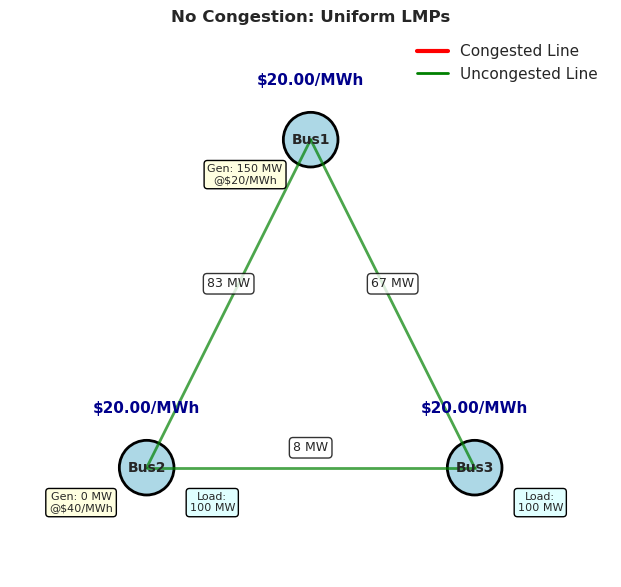

In [39]:
# Visualize both scenarios
visualize_network_results(
    results_no_cong, buses, generators, lines,
    "No Congestion: Uniform LMPs"
)

With no transmission constraints binding, all buses have the same LMP equal to the marginal generator's cost. The cheaper generator at Bus1 (G1) is marginal, setting the system price at \$20/MWh. This uniform pricing indicates that an additional MW of load anywhere in the system would be served by the same marginal generator.

### Scenario 2: Transmission Congestion

Now, let's increase the load level to create congestion. When transmission constraints bind, the system cannot fully utilize cheap generation, forcing expensive local generation to run. This creates different prices at different locations.

In [26]:
buses.demand = [0, 100, 100]

In [27]:
results_cong = solve_3bus_opf(
    buses, generators, lines, ptdf, bus_map
)

In [28]:
print("SCENARIO 2: WITH TRANSMISSION CONGESTION")
print("="*50)
print(f"\nTotal Cost: ${results_cong['total_cost']:,.2f}")
print(f"System LMP: ${results_cong['system_lmp']:.2f}/MWh")

# Calculate cost increase
cost_increase = results_cong['total_cost'] - results_no_cong['total_cost']
pct_increase = cost_increase / results_no_cong['total_cost'] * 100
print(f"\nCost increase due to congestion: ${cost_increase:.2f} ({pct_increase:.1f}%)")

SCENARIO 2: WITH TRANSMISSION CONGESTION

Total Cost: $4,285.71
System LMP: $20.00/MWh

Cost increase due to congestion: $1285.71 (42.9%)


In [29]:
# Display constrained dispatch
print("\nGeneration Dispatch (Constrained):")
for g_id, g_val in results_cong['generation'].items():
    g_cost = generators.loc[g_id, 'cost']
    g_val_uncong = results_no_cong['generation'][g_id]
    change = g_val - g_val_uncong
    print(f"  {g_id}: {g_val:.1f} MW @ ${g_cost}/MWh")
    if abs(change) > 0.1:
        print(f"    → Change from uncongested: {change:+.1f} MW")


Generation Dispatch (Constrained):
  G1_Cheap: 185.7 MW @ $20/MWh
    → Change from uncongested: +35.7 MW
  G2_Expensive: 14.3 MW @ $40/MWh
    → Change from uncongested: +14.3 MW


In [32]:
# Display congested line flows
print("\nTransmission Line Flows (Constrained):")
for i, line_name in enumerate(lines.index):
    flow = results_cong['line_flows'][i]
    limit = lines.limit.values[i]
    loading = abs(flow) / limit * 100
    
    status = "⚠️ CONGESTED" if loading >= 99 else "OK"
    print(f"  {line_name}: {flow:+.1f} MW / {limit} MW ({loading:.1f}% loaded) {status}")

if results_cong['congestion_prices']:
    print("\nCongestion Shadow Prices:")
    for line, price in results_cong['congestion_prices'].items():
        print(f"  {line}: ${price:.2f}/MW")
        print(f"    → Cost of congestion on this line")


Transmission Line Flows (Constrained):
  L1_1-2: +100.0 MW / 100 MW (100.0% loaded) ⚠️ CONGESTED
  L2_1-3: +85.7 MW / 200 MW (42.9% loaded) OK
  L3_2-3: +14.3 MW / 200 MW (7.1% loaded) OK

Congestion Shadow Prices:
  L1_1-2: $-25.71/MW
    → Cost of congestion on this line


In [35]:
def visualize_network_results(results, buses, generators, lines, title):
    """Create network visualization showing flows and prices."""
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Bus positions (triangle layout)
    pos = {
        'Bus1': (0.5, 0.8),
        'Bus2': (0.2, 0.2),
        'Bus3': (0.8, 0.2)
    }
    
    # Draw buses
    for bus, (x, y) in pos.items():
        circle = plt.Circle((x, y), 0.05, facecolor='lightblue', 
                           edgecolor='black', linewidth=2)
        ax.add_patch(circle)
        ax.text(x, y, bus, ha='center', va='center', 
               fontsize=10, fontweight='bold')
    
    # Draw transmission lines
    for line_idx, (line_name, line) in enumerate(lines.iterrows()):
        from_pos = pos[line['from_bus']]
        to_pos = pos[line['to_bus']]
        
        flow = results['line_flows'][line_idx]
        limit = lines.limit.values[line_idx]
        loading = abs(flow) / limit * 100
        
        # Color based on congestion
        if loading >= 95:
            color = 'red'
            width = 3
        else:
            color = 'green'
            width = 2
        
        ax.plot([from_pos[0], to_pos[0]], [from_pos[1], to_pos[1]], 
               color=color, linewidth=width, alpha=0.7)
        
        # Add flow label
        mid_x, mid_y = (from_pos[0]+to_pos[0])/2, (from_pos[1]+to_pos[1])/2
        flow_text = f"{flow:.0f} MW"
        ax.text(mid_x, mid_y+0.03, flow_text, ha='center', fontsize=9,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add generation and load labels
    for bus_name in buses.index:
        x, y = pos[bus_name]
        
        # Generation info
        gen_at_bus = generators[generators['bus'] == bus_name]
        if len(gen_at_bus) > 0:
            g_id = gen_at_bus.index[0]
            gen_val = results['generation'][g_id]
            gen_cost = gen_at_bus.iloc[0]['cost']
            gen_text = f"Gen: {gen_val:.0f} MW\n@${gen_cost}/MWh"
            ax.text(x-0.12, y-0.08, gen_text, ha='center', fontsize=8,
                   bbox=dict(boxstyle='round', facecolor='lightyellow'))
        
        # Load info
        load = buses.loc[bus_name, 'demand']
        if load > 0:
            ax.text(x+0.12, y-0.08, f"Load:\n{load:.0f} MW", 
                   ha='center', fontsize=8,
                   bbox=dict(boxstyle='round', facecolor='lightcyan'))
        
        # LMP
        lmp = results['lmps'][bus_name]
        ax.text(x, y+0.1, f'${lmp:.2f}/MWh', fontsize=11, 
               fontweight='bold', color='darkblue', ha='center')
    
    # Legend
    ax.plot([], [], 'r-', linewidth=3, label='Congested Line')
    ax.plot([], [], 'g-', linewidth=2, label='Uncongested Line')
    ax.legend(loc='upper right')
    
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(0, 1.0)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

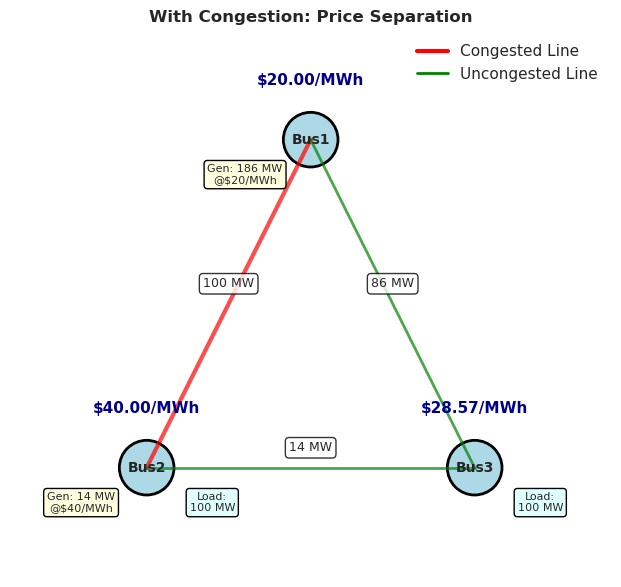

In [38]:
visualize_network_results(
    results_cong, buses, generators, lines,
    "With Congestion: Price Separation"
)

### Economic Interpretation of Results

The congestion on Line L1 (Bus1→Bus2) prevents full utilization of cheap generation at Bus1, forcing expensive generation at Bus2 to increase output. This creates three distinct price zones:

**Bus1** has the lowest LMP ($20/MWh) because it's the source of cheap generation. Additional load here would be served by the local cheap generator without stressing the congested line.

**Bus2** has the highest LMP ($40/MWh) because it's import-constrained. The congested line prevents importing more cheap power, so additional load must be served by expensive local generation.

**Bus3** has an intermediate LMP ($28.57/MWh) reflecting its position in the network. It can receive some power from Bus1 via the uncongested L2 line, but also draws from the expensive Bus2 generation.

## Two-Settlement Markets

Modern electricity markets operate through multiple settlement periods to manage uncertainty and ensure reliability. The day-ahead market closes approximately 24 hours before the operating day, allowing generators to commit units and schedule fuel deliveries. During the operating day, the real-time market runs every five minutes to handle deviations from day-ahead schedules caused by forecast errors, forced outages, or unexpected events.

This two-settlement structure balances competing objectives. The day-ahead market provides financial certainty and operational planning time, essential for thermal generators with long startup times. The real-time market ensures continuous balance between supply and demand, dispatching flexible resources to handle uncertainty. Together, they create a robust system that maintains reliability while providing appropriate price signals.

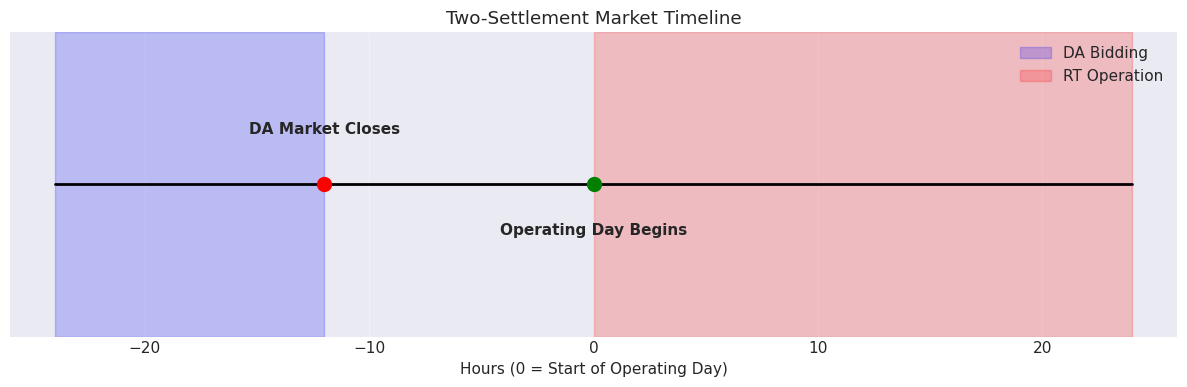

In [13]:
# Market timeline visualization
fig, ax = plt.subplots(figsize=(12, 4))

# Timeline
timeline = np.array([-24, -12, 0, 6, 12, 18, 24])
ax.plot(timeline, [0]*len(timeline), 'k-', linewidth=2)

# Mark key times
ax.plot(-12, 0, 'ro', markersize=10)
ax.text(-12, 0.1, 'DA Market Closes', ha='center', fontweight='bold')

ax.plot(0, 0, 'go', markersize=10)
ax.text(0, -0.1, 'Operating Day Begins', ha='center', fontweight='bold')

# Shade periods
ax.axvspan(-24, -12, alpha=0.2, color='blue', label='DA Bidding')
ax.axvspan(0, 24, alpha=0.2, color='red', label='RT Operation')

# Labels
ax.set_xlim(-26, 26)
ax.set_ylim(-0.3, 0.3)
ax.set_xlabel('Hours (0 = Start of Operating Day)')
ax.set_title('Two-Settlement Market Timeline')
ax.legend(loc='upper right')
ax.set_yticks([])
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

### Settlement Mathematics

The financial settlement in two-settlement markets follows specific rules that create appropriate incentives. Generators receive the day-ahead price for their day-ahead schedule and the real-time price for any deviations. This structure encourages accurate scheduling while allowing profitable responses to real-time conditions.

Consider a generator scheduled for 100 MW in the day-ahead market at \$30/MWh. If it actually produces 110 MW in real-time when prices are \$35/MWh, its revenue combines both settlements: \$30 × 100 MW for the day-ahead position plus \$35 × 10 MW for the additional real-time production. This mechanism ensures generators have incentives to follow dispatch instructions while responding to real-time price signals.

### Price Formation and Volatility

Electricity prices exhibit unique volatility patterns driven by the inability to store power economically. Unlike other commodities where inventory buffers supply and demand imbalances, electricity markets must clear instantaneously. This creates price spikes during scarcity and occasional negative prices during oversupply, particularly with high renewable generation.

Forecast errors are the primary driver of price differences between day-ahead and real-time markets. When actual demand exceeds forecasts, the system must quickly dispatch expensive peaking units, driving real-time prices above day-ahead levels. Conversely, overforecasting leads to excess committed generation that must be backed down, potentially causing real-time prices to fall below day-ahead prices. These price patterns create opportunities for flexible resources and financial traders while signaling the value of improved forecasting.

In [14]:
# Generate sample price data showing volatility
np.random.seed(42)
hours = np.arange(24)

# DA prices with daily pattern
da_prices = 30 + 15 * np.sin((hours - 6) * np.pi / 12) + np.random.normal(0, 2, 24)

# RT prices with forecast error impact
forecast_error = np.random.normal(0, 50, 24)  # MW
rt_prices = da_prices + 0.1 * forecast_error + np.random.normal(0, 3, 24)

# Calculate spread
price_spread = rt_prices - da_prices

print("Price Statistics:")
print(f"  Mean DA Price: ${da_prices.mean():.2f}/MWh")
print(f"  Mean RT Price: ${rt_prices.mean():.2f}/MWh")
print(f"  Max Spread: ${price_spread.max():.2f}/MWh")
print(f"  Min Spread: ${price_spread.min():.2f}/MWh")

Price Statistics:
  Mean DA Price: $29.70/MWh
  Mean RT Price: $28.68/MWh
  Max Spread: $12.06/MWh
  Min Spread: $-10.36/MWh


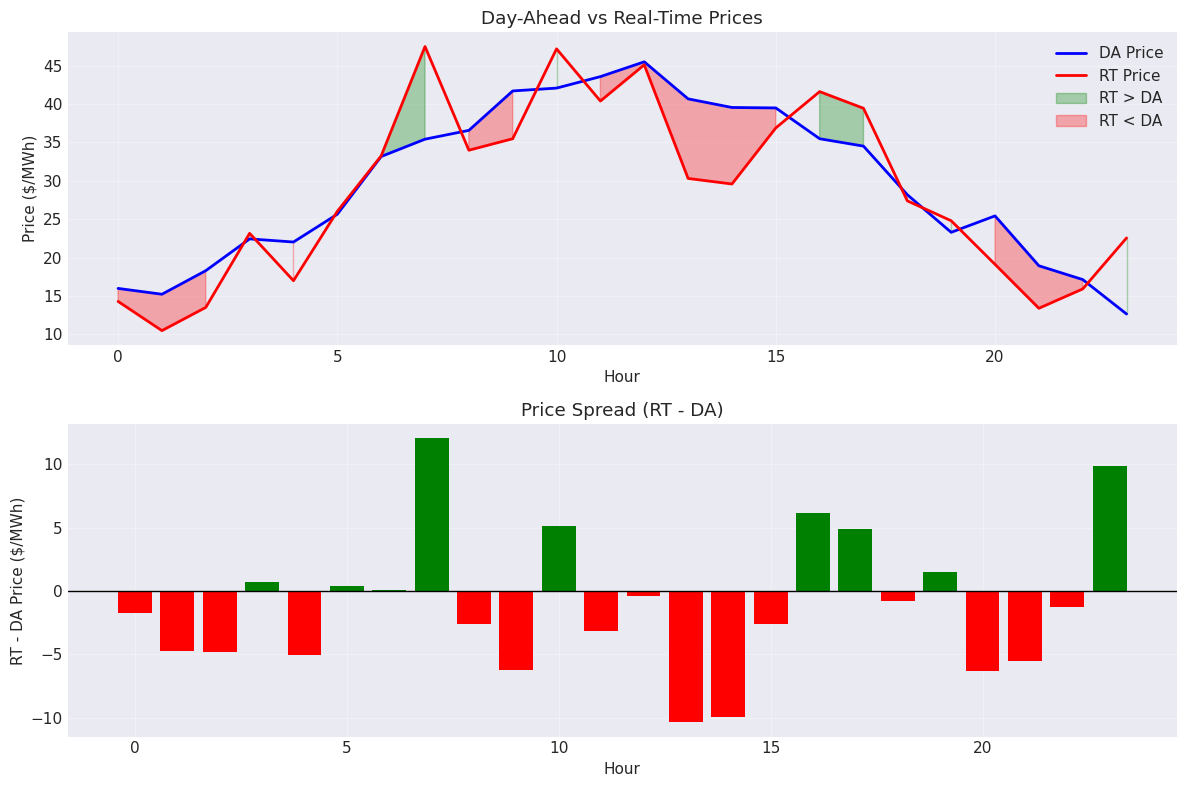

In [15]:
# Visualize price patterns
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Price comparison
ax1.plot(hours, da_prices, 'b-', linewidth=2, label='DA Price')
ax1.plot(hours, rt_prices, 'r-', linewidth=2, label='RT Price')
ax1.fill_between(hours, da_prices, rt_prices, 
                  where=(rt_prices > da_prices), 
                  color='green', alpha=0.3, label='RT > DA')
ax1.fill_between(hours, da_prices, rt_prices, 
                  where=(rt_prices <= da_prices), 
                  color='red', alpha=0.3, label='RT < DA')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Price ($/MWh)')
ax1.set_title('Day-Ahead vs Real-Time Prices')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Price spread
ax2.bar(hours, price_spread, color=['green' if s > 0 else 'red' for s in price_spread])
ax2.axhline(y=0, color='black', linewidth=1)
ax2.set_xlabel('Hour')
ax2.set_ylabel('RT - DA Price ($/MWh)')
ax2.set_title('Price Spread (RT - DA)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Market Power and Competition

Market power, the ability to profitably raise prices above competitive levels, poses a constant concern in electricity markets. The combination of inelastic demand, transmission constraints, and limited storage creates opportunities for generators to exercise market power, especially during high-demand periods. Understanding and mitigating market power is essential for maintaining competitive markets.

Several metrics help identify market power potential. Market concentration, measured by the Herfindahl-Hirschman Index (HHI), indicates whether a few large suppliers dominate the market. The pivotal supplier test identifies generators whose capacity is essential to meet demand—these suppliers know the system needs them and can bid strategically. When multiple indicators suggest market power concerns, regulators implement mitigation measures such as bid caps or must-offer requirements.

In [40]:
# Calculate market concentration metrics
market_shares = np.array([0.35, 0.25, 0.20, 0.15, 0.05])  # Five suppliers
supplier_names = ['MegaCorp', 'PowerGen', 'GreenEnergy', 'LocalUtil', 'SmallGen']

# Herfindahl-Hirschman Index
hhi = sum((share * 100) ** 2 for share in market_shares)

print("Market Concentration Analysis:")
print(f"\nHHI: {hhi:.0f}")
print("  < 1500: Unconcentrated")
print("  1500-2500: Moderately concentrated")
print("  > 2500: Highly concentrated")
print(f"\nStatus: {'Highly concentrated' if hhi > 2500 else 'Moderately concentrated' if hhi > 1500 else 'Unconcentrated'}")

# Pivotal supplier analysis
total_capacity = 1000  # MW
peak_demand = 850  # MW
supplier_capacities = market_shares * total_capacity

print("\nPivotal Supplier Test (Peak Demand = 850 MW):")
for name, capacity in zip(supplier_names, supplier_capacities):
    others_capacity = total_capacity - capacity
    is_pivotal = others_capacity < peak_demand
    print(f"  {name}: {'PIVOTAL' if is_pivotal else 'Not pivotal'}")

Market Concentration Analysis:

HHI: 2500
  < 1500: Unconcentrated
  1500-2500: Moderately concentrated
  > 2500: Highly concentrated

Status: Moderately concentrated

Pivotal Supplier Test (Peak Demand = 850 MW):
  MegaCorp: PIVOTAL
  PowerGen: PIVOTAL
  GreenEnergy: PIVOTAL
  LocalUtil: Not pivotal
  SmallGen: Not pivotal


The pivotal supplier test reveals which generators have significant market power. When a supplier is pivotal, the system cannot meet demand without them, giving them the ability to raise prices knowing they must be dispatched. This structural market power exists regardless of the supplier's behavior and requires regulatory oversight to prevent abuse.

## Exercises

### Exercise 1: Market Clearing Verification

A fundamental principle of competitive electricity markets states that the market-clearing price equals the marginal cost of the most expensive generator that is dispatched (the marginal unit). This exercise explores this relationship and what happens when demand changes slightly.

Using the generator data provided, solve the market-clearing problem for a demand of 950 MW using linear programming. Extract both the dispatch solution and the LMP from the dual variable. Then identify which generator is marginal, i.e., the highest-cost unit that is producing power, and then compare its marginal cost to the LMP. They should be equal in an unconstrained market. Finally, calculate the total cost of serving this demand and the producer surplus for each generator.

**Hint:** The marginal generator is the one with the highest marginal cost among those with non-zero dispatch. Use the `.pi` attribute of the power balance constraint to get the LMP directly. This is the shadow price that represents the marginal cost of serving one additional MW of demand.

In [17]:
# Exercise 1: Your code here
exercise_gens = pd.DataFrame({
    'name': ['Coal_A', 'Coal_B', 'Gas_A', 'Gas_B', 'Peaker'],
    'capacity': [350, 300, 250, 200, 100],
    'marginal_cost': [22, 26, 32, 38, 65]
})

demand = 950  # MW

# Your solution here

### Exercise 2: Price Spread Arbitrage

Price differences between day-ahead and real-time markets create arbitrage opportunities for participants who can accurately predict these spreads. This exercise examines the economic value of perfect foresight and the risks involved in spread trading.

You're given hourly day-ahead and real-time prices for a 24-hour period. Calculate the profit from perfect arbitrage with a 10 MW position: buy in the cheaper market and sell in the more expensive one for each hour. Sum your profits across all hours to find the total arbitrage value. Then analyze the risk by calculating what would happen if you always bought day-ahead and sold real-time (a directional bet) versus the perfect arbitrage strategy.

**Hint:** For each hour, the arbitrage profit is `position_size × |RT_price - DA_price|`. You buy in the cheaper market and sell in the expensive one. For the directional strategy, profit is `position_size × (RT_price - DA_price)`, which can be negative if RT < DA.

In [18]:
# Exercise 2: Your code here
np.random.seed(100)
da_prices = 30 + 5 * np.random.randn(24)
rt_prices = da_prices + 3 * np.random.randn(24)

position_size = 10  # MW

# Your solution here

### Exercise 3: Settlement Calculation

Understanding two-settlement market mathematics is crucial for generators optimizing their revenues. This exercise walks through a complete settlement calculation for a generator participating in both day-ahead and real-time markets.

A generator has the following schedule and actual output over 4 hours. For each hour, calculate the day-ahead revenue (DA schedule × DA price), the real-time deviation revenue ((RT output - DA schedule) × RT price), and the total revenue. Note that deviation revenue can be negative if the generator underproduces when real-time prices are high. Sum across all hours to find total revenues and identify which hours contributed most to profitability.

**Hint:** Create a new column for DA revenue, RT deviation revenue, and total revenue. The deviation can be positive (overgeneration) or negative (undergeneration). When RT price > DA price, overgeneration is profitable.

In [19]:
# Exercise 3: Your code here
schedule_data = pd.DataFrame({
    'hour': [1, 2, 3, 4],
    'da_schedule': [100, 100, 150, 120],
    'da_price': [25, 28, 35, 30],
    'rt_output': [95, 110, 150, 125],
    'rt_price': [22, 32, 40, 28]
})

# Your solution here

## Summary

This lesson introduced the fundamental concepts that enable competitive electricity markets to function efficiently. You learned how merit order dispatch minimizes costs, why uniform pricing creates appropriate incentives, and how transmission constraints lead to locational price differences. The two-settlement system balances planning certainty with operational flexibility, while market power metrics help identify potential competition problems.

These concepts form the foundation for understanding modern grid operations. As you progress to studying network-constrained optimization and unit commitment, remember that the economic principles: marginal cost pricing, producer surplus, and settlement mathematics. Despite some imperfections, those principles are seen throughout electricity market designs.